In [1]:
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras
from keras.layers import Activation
from keras import backend as K
keras.backend.set_floatx('float64')

Generate the grid that we want to learn

In [2]:
strike = np.arange(-0.02, 0.025, step=0.005)
optMats = [0.5, 1, 2, 5, 10, 15, 20, 30]

grid = {
    'chgStrike' : strike,
    'optMat' : optMats
}
keys, values = zip(*grid.items())
combinations = [dict(zip(keys, v)) for v in product(*values)]
combinations = pd.DataFrame(combinations)

print("Number of combinations:",len(combinations))
print(len(strike), len(optMats))

Number of combinations: 72
9 8


Import data

In [3]:
from google.colab import drive
drive.mount("/content/drive")

path = "/content/drive/My Drive/Colab Notebooks"
X = X = pd.read_csv(f"{path}/data/2DpricingVector-input.csv")
X["sigma"] = np.maximum(X["sigma"], 1e-12)
y = pd.read_csv(f"{path}/data/2DgridImpliedVolatility.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Split train and test, scale values and do PCA if required

In [4]:
PCA = True

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# Split train test
TRAINING_SIZE = 0.8
split = int(TRAINING_SIZE*X.shape[0])
X_tr, X_te = X[:split].reset_index(drop=True), X[split:].reset_index(drop=True)
y_tr, y_te = y[:split].reset_index(drop=True), y[split:].reset_index(drop=True)

# Extract curve
curveCols = X.columns[X.columns.str.contains("yrs")]
curve_tr, curve_te = X_tr[curveCols].copy(), X_te[curveCols].copy()

if PCA:
  # Std scaler
  scaler = StandardScaler()
  curve_tr_sc, curve_te_sc = scaler.fit_transform(curve_tr), scaler.transform(curve_te)
  # PCA
  comps=3
  pca = PCA(n_components=comps)
  curve_tr_pca, curve_te_pca = pca.fit_transform(curve_tr_sc), pca.transform(curve_te_sc)
  curve_tr_pca, curve_te_pca = pd.DataFrame(curve_tr_pca), pd.DataFrame(curve_te_pca)
  colNames = [f"comp_{x}" for x in range(0, comps)]
  curve_tr_pca.columns, curve_te_pca.columns = colNames, colNames
  # Merge data 
  X_tr_clean = pd.concat([curve_tr_pca, X_tr.drop(columns=curveCols)], axis=1)
  X_te_clean = pd.concat([curve_te_pca, X_te.drop(columns=curveCols)], axis=1)
  # Scale between -1 and 1
  rng = MinMaxScaler(feature_range=(-1, 1))
  X_tr_clean, X_te_clean = rng.fit_transform(X_tr_clean), rng.transform(X_te_clean)
else:
  rng = rng = MinMaxScaler(feature_range=(-1, 1))
  X_tr_clean, X_te_clean = rng.fit_transform(X_tr), rng.transform(X_te)

scaleY = StandardScaler()
y_tr_clean, y_te_clean = scaleY.fit_transform(y_tr), scaleY.transform(y_te) 

Create the NN and train

In [6]:
import keras
from keras.layers import Activation
from keras import backend as K
keras.backend.set_floatx('float64')

def create_model():


  input1 = keras.layers.Input(shape=(X_tr_clean.shape[1],))
  x1 = keras.layers.Dense(32,activation = 'elu')(input1)
  x2=keras.layers.Dense(32,activation = 'elu')(x1) 
  x3=keras.layers.Dense(32,activation = 'elu')(x2) 
  output1=keras.layers.Dense(y_tr_clean.shape[1],activation = 'linear')(x3)

  model = keras.models.Model(inputs=input1, outputs=output1)
  print(model.summary())
  return model

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
lrReduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss")

model = create_model()
model.compile(loss=rmse, optimizer="adam")

history = model.fit(
    x=X_tr_clean,
    y=y_tr_clean,
    batch_size=32,
    epochs=200,
    validation_split=0.2,
    callbacks=[earlyStop, lrReduce]
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 72)                2376      
Total params: 4,680
Trainable params: 4,680
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2465 - val_loss: 0.0753
Epoch 2/200
2000/

In [7]:
# Save model
model.save_weights(f"model-impliedVolGrid-NN:pca{PCA}.h5")
model = create_model()
model.load_weights (f"model-impliedVolGrid-NN:pca{PCA}.h5")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 72)                2376      
Total params: 4,680
Trainable params: 4,680
Non-trainable params: 0
_________________________________________________________________
None


Plot training history

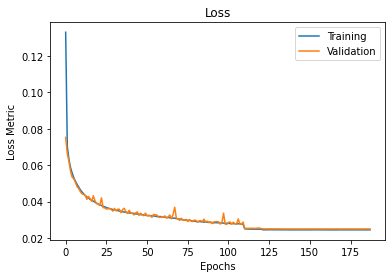

In [8]:
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss Metric")
plt.legend()
plt.show()



Make predictions and compute metrics on test set

RMSE: 0.00014199530034451075
R^2: 0.9990063854670823


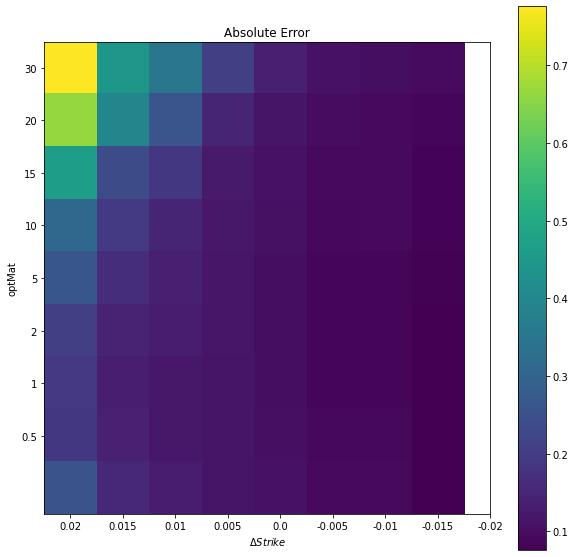

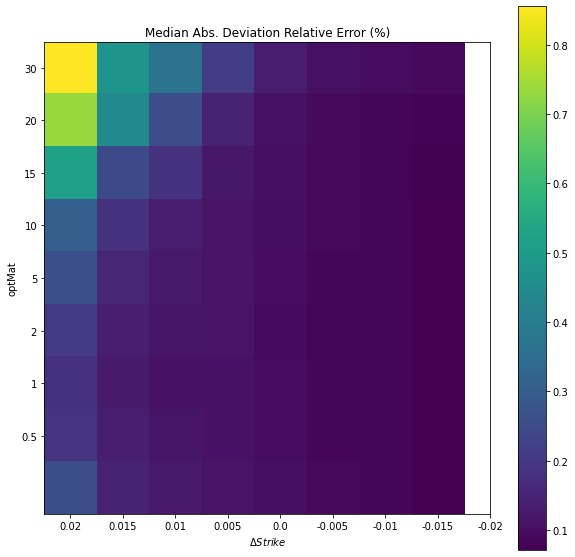

In [9]:
from scipy.stats import median_absolute_deviation as mad
# Compute predictions
pred_oos = model.predict(X_te_clean)
pred_oos = scaleY.inverse_transform(pred_oos)

def r2score(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

m = keras.metrics.RootMeanSquaredError()
m.update_state(y_te, pred_oos)
print("RMSE:",m.result().numpy())

r2 = r2score(y_te.values, pred_oos)
print("R^2:", r2)


# Plot relative error
err = 10000 * np.abs(pred_oos - y_te.values)
error = np.median( err,axis=0)
strike = np.around(strike,3)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(error.reshape(len(strike), len(optMats)))
plt.colorbar()
ax.set_xticks(np.linspace(0,len(strike)-1,len(strike)))
ax.set_xticklabels(strike[::-1])
ax.set_yticks(np.linspace(0,len(optMats)-1,len(optMats)))
ax.set_yticklabels(optMats[::-1])
ax.set_xlabel(r"$\Delta Strike$")
ax.set_ylabel("optMat")
plt.title("Absolute Error")
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(mad(err).reshape(len(strike), len(optMats)))
plt.colorbar()
ax.set_xticks(np.linspace(0,len(strike)-1,len(strike)))
ax.set_xticklabels(strike[::-1])
ax.set_yticks(np.linspace(0,len(optMats)-1,len(optMats)))
ax.set_yticklabels(optMats[::-1])
ax.set_xlabel(r"$\Delta Strike$")
ax.set_ylabel("optMat")
plt.title("Median Abs. Deviation Relative Error (%)")
plt.show()


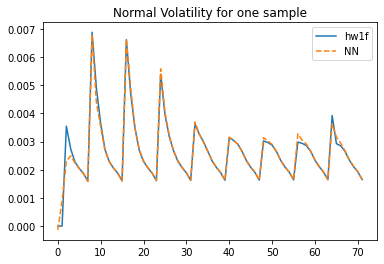

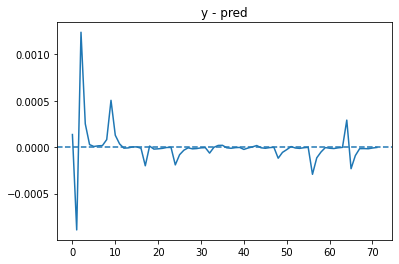

10


In [10]:
# Plot metrics for a single sample

randomIdx = np.random.choice(np.arange(0, y_te.shape[0]))
sample_y = y_te.iloc[randomIdx].values
sample_pred = pred_oos[randomIdx]

sigma, swapMat = X_te.loc[randomIdx, 'sigma'], X_te.loc[randomIdx, 'swapMat']

plt.plot(sample_y, label="hw1f")
plt.plot(sample_pred, label="NN", ls="--")
plt.legend()
plt.title("Normal Volatility for one sample")
plt.show()

plt.plot(sample_y - sample_pred)
plt.title("y - pred")
plt.axhline(0, ls="--")
plt.show()

print(swapMat)

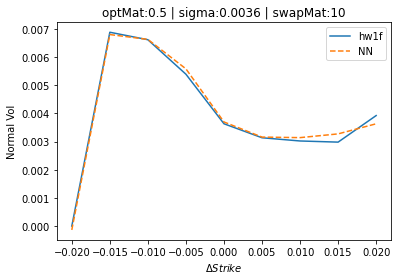

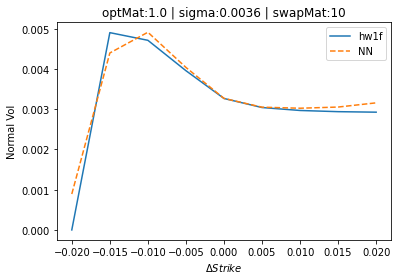

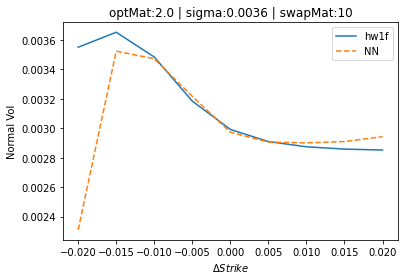

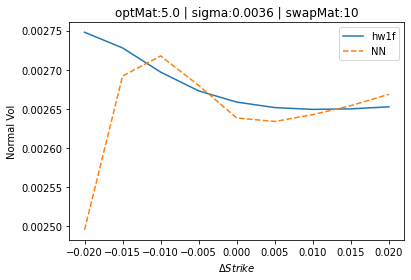

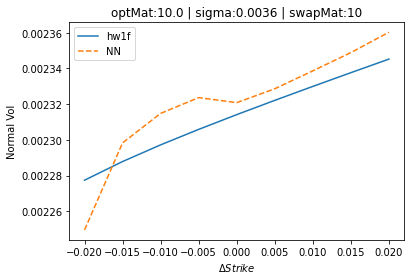

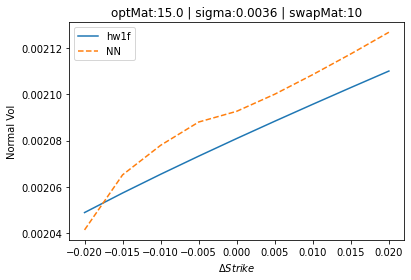

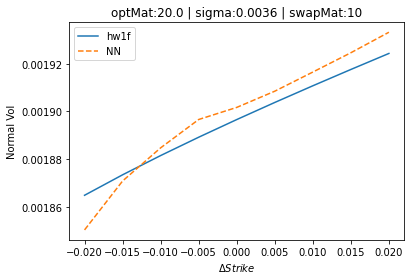

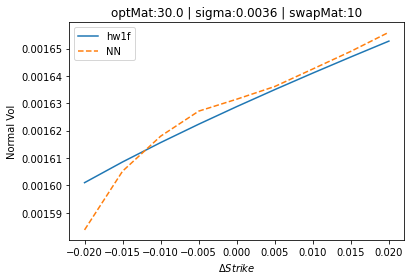

In [11]:
for optMat in combinations["optMat"].unique():
    lkp = combinations[(combinations["optMat"]==optMat)]
    plt.plot(lkp["chgStrike"], sample_y[lkp.index], label="hw1f")
    plt.plot(lkp["chgStrike"], sample_pred[lkp.index], label="NN", ls="--")
    plt.xlabel(r"$\Delta Strike$")
    plt.ylabel("Normal Vol")
    plt.legend()
    plt.title(f"optMat:{optMat} | sigma:{sigma:.4f} | swapMat:{swapMat}")
    
    plt.show()

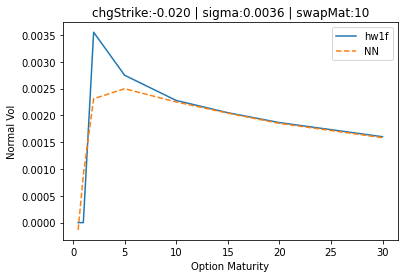

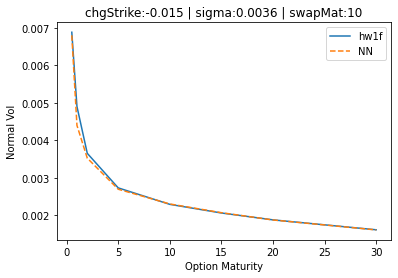

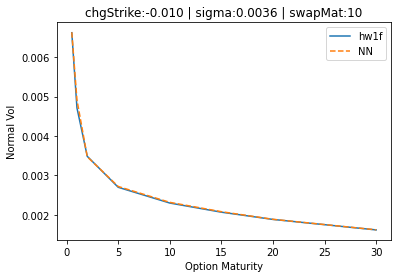

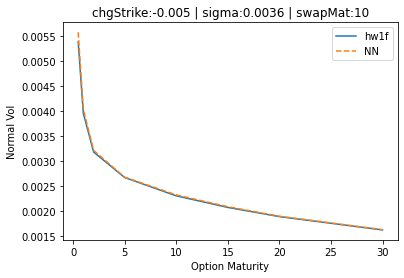

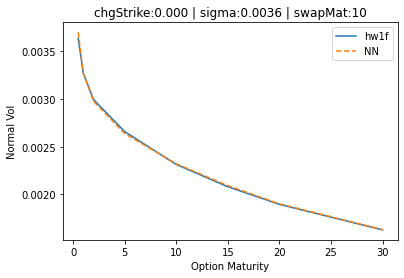

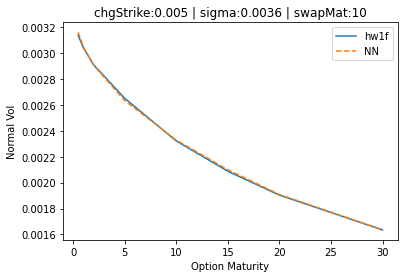

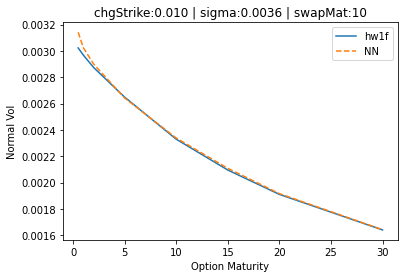

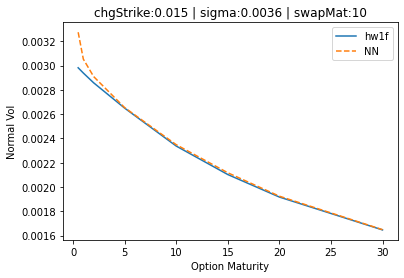

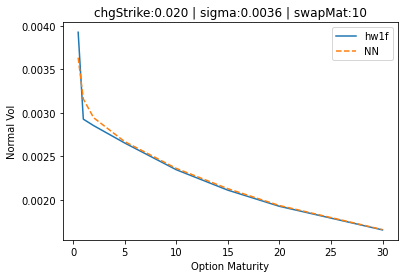

In [12]:
for chgStrike in combinations["chgStrike"].unique():
    lkp = combinations[(combinations["chgStrike"]==chgStrike)]
    plt.plot(lkp["optMat"], sample_y[lkp.index], label="hw1f")
    plt.plot(lkp["optMat"], sample_pred[lkp.index], label="NN", ls="--")
    plt.legend()
    plt.xlabel("Option Maturity")
    plt.ylabel("Normal Vol")
    plt.title(f"chgStrike:{chgStrike:.3f} | sigma:{sigma:.4f} | swapMat:{swapMat}")
    
    plt.show()